<h1><center> Application of Gaussian Process Regressions in Finance  </center></h1>


Welcome to this notebook, which demonstrates a brief session on $\mathcal{GPR}$ from the course $\textbf{Machine Learning in Finance: Theoretical Foundations}$. This notebook aims to showcase how $\mathcal{GPR}$ can be efficiently implemented in Python using various libraries, and how it can be applied to pricing tasks in finance and insurance.


<h2> Summary of the lecture : </h2>

- [Some simple applications of GPR for pricing in finance and insurance](#applications)
  - [A Call Option and Delta under B-S model](#call-BS)
  - [A GMMB contract in insurance](#gmmb-insurance)
- [An application of GPR and Monte-Carlo for CVA computation in finance](#gpr-MC)
  - [What is Credit Valuation Adjustment (CVA) ?](#what-is-CVA?)
  - [The GPR-MC methodology for CVA and applications](#cva-GPRMC)
- [References](#references)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
colors = plt.get_cmap('Set2').colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF #This package imports the Kernels
import scipy as sp
import scipy.stats as st
import math





<h4> Defining some useful $Black-Scholes$ formulas and $GBM$ dynamics </h4>  

In [3]:
def bsformula(cp, s, k, rf, t, v, div):
        """ Price an option using the Black-Scholes model.
        cp: +1/-1 for call/put
        s: initial stock price
        k: strike price
        t: expiration time
        v: volatility
        rf: risk-free rate
        div: dividend
        """

        d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
        d2 = d1 - v*np.sqrt(t)

        optprice = (cp*s*np.exp(-div*t)*st.norm.cdf(cp*d1)) - (cp*k*np.exp(-rf*t)*st.norm.cdf(cp*d2))
        delta = cp*st.norm.cdf(cp*d1)
        vega  = s*np.sqrt(t)*st.norm.pdf(d1)
        binary = np.exp(-rf*t)*st.norm.cdf(cp*d2)
        deltabinary = np.exp(-rf*t)*norm.pdf(cp*d2) / (s * v * np.sqrt(t))
        return optprice, delta, vega,binary,deltabinary
    
def gbm(S0, mu, sigma, T = 1., N = 10, M= 1000): 
    
    dt = T/ float(N) 
    S= np.array([S0]*(N+1)*M, dtype='float32').reshape(N+1, M)  
    for i in range(N):      
        dS = S[i,]*(mu*dt +  sigma*np.sqrt(dt)*np.random.randn(M))
        S[i+1,]=S[i,] + dS 
    return S

<a id=applications></a>
<h2> <center> Some simple applications of GPR for pricing in finance and insurance  </center> </h2>




<a id=call-BS></a>
<h3> <center> A Call option and Greeks under B-S model </center> </h3>


<h4> Setting model parameters : </h4>

In [4]:
# Setting model parameters
r = 0.03
sigma = 0.3
t=0
T = 1
S0 = 100
K=100

<h4> Defining function prices formulas in the $B-S$ model : </h4>

In [5]:
lb = 0
ub = 300
training_number = 40
testing_number = 40
sigma_n = 1e-8 # additive noise in GP

call = lambda x,y: bsformula(1, lb+(ub-lb)*x, K, r, T, y, 0)[0]
delta= lambda x,y: bsformula(1, lb+(ub-lb)*x, K, r, T, y, 0)[1]
vega = lambda x, y: bsformula(1, lb + (ub-lb) * x, K, r, T, y, 0)[2]
binarycallprice = lambda x,y: bsformula(1, lb+(ub-lb)*x, K, r, T, y, 0)[3]
deltabinary = lambda x,y : bsformula(1,lb+(ub-lb)*x,K,r,T,y,0)[4]
gbm =

SyntaxError: invalid syntax (1915237951.py, line 12)

<h4> Training and fitting the $\mathcal{GPR}$ to learn the Call Price function and the Delta by differentiation : </h4>

In [6]:
x_train = np.array(np.linspace(0.1,1.0, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.1,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call(x_train[idx], sigma))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) 
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
 
    
# Computing the Delta     
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
    
Kernel= rbf(x_train, x_train) # Computation of matrix K_(xi,xj)
K_y = Kernel + np.eye(training_number) * sigma_n
L= sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train)
    
k_s = rbf(x_test, x_train) # Computation of K_{X,X*}
k_s_prime = (x_train.T - x_test) * k_s / l**2

f_prime = np.dot(k_s_prime, alpha_p)/(ub-lb) # Computing the Delta 

NameError: name 'training_number' is not defined

<h3> Some Numerical results : </h3>


<h4> Plotting the Call Price and the associated error: </h4>

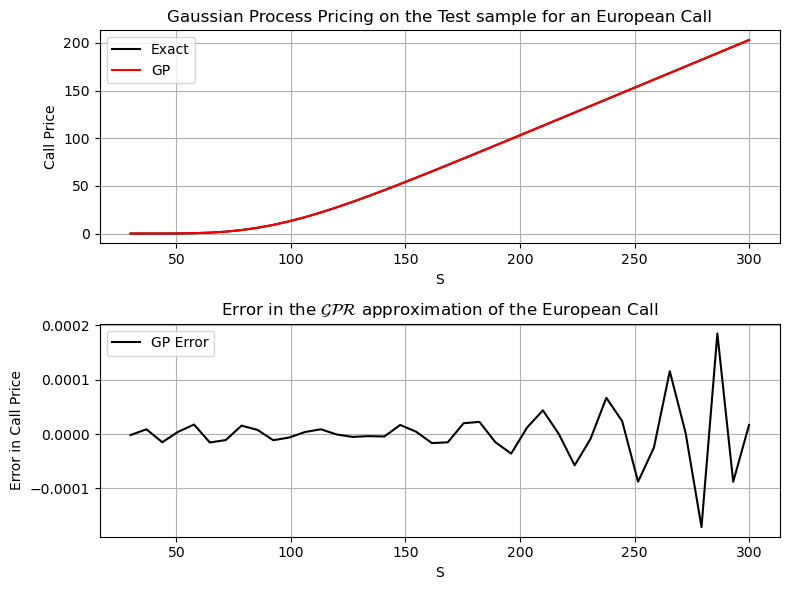

In [94]:
fig, axs = plt.subplots(2,1, figsize=(8, 6))  # Deux sous-graphiques en colonne

# Premier graphique : Prix exact vs GP
axs[0].plot(lb + (ub - lb) * x_test, call(x_test, sigma), color='black', label='Exact')
axs[0].plot(lb + (ub - lb) * x_test, y_pred, color='red', label='GP')
axs[0].grid(True)
axs[0].set_xlabel('S')
axs[0].set_ylabel('Call Price')
axs[0].set_title("Gaussian Process Pricing on the Test sample for an European Call")
axs[0].legend()

# Deuxième graphique : Erreur de l'approximation GP
axs[1].plot(lb + (ub - lb) * x_test, call(x_test, sigma).reshape((40,)) - y_pred, color='black', label='GP Error')
axs[1].grid(True)
axs[1].set_xlabel('S')
axs[1].set_ylabel('Error in Call Price')
axs[1].set_title(r"Error in the $\mathcal{GPR}$ approximation of the European Call")
axs[1].legend()

plt.tight_layout()  # Ajuste l'affichage pour éviter le chevauchement
# plt.savefig("Images/ErrorCallPrice.png")  # Pour sauvegarder l'image
plt.show()


<h4> Plotting the Delta and associated error : </h4>

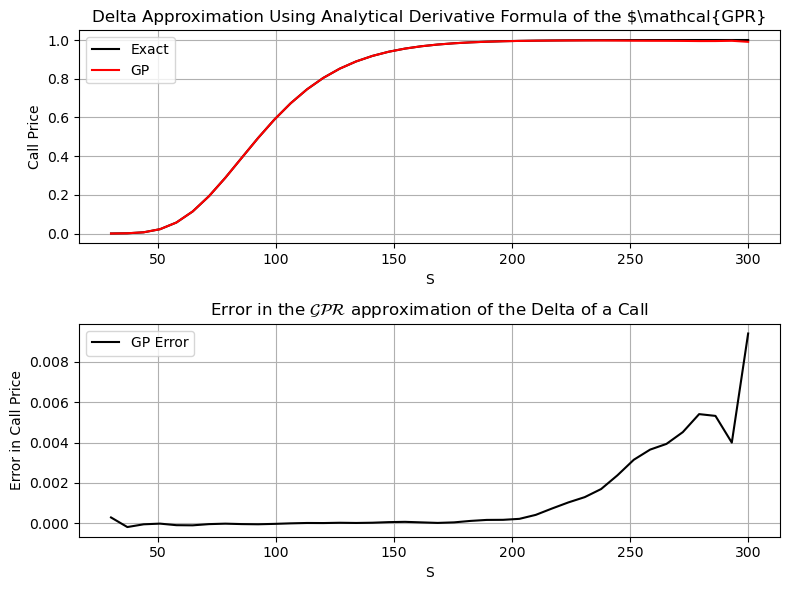

In [96]:

fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Deux sous-graphiques en colonne

# Premier graphique : Prix exact vs GP
axs[0].plot(lb + (ub - lb) * x_test, delta(x_test, sigma), color='black', label='Exact')
axs[0].plot(lb + (ub - lb) * x_test, f_prime, color='red', label='GP')
axs[0].grid(True)
axs[0].set_xlabel('S')
axs[0].set_ylabel('Call Price')
axs[0].set_title("Delta Approximation Using Analytical Derivative Formula of the $\mathcal{GPR}")
axs[0].legend()

# Deuxième graphique : Erreur de l'approximation GP
axs[1].plot(lb + (ub - lb) * x_test, delta(x_test, sigma) - f_prime, color='black', label='GP Error')
axs[1].grid(True)
axs[1].set_xlabel('S')
axs[1].set_ylabel('Error in Call Price')
axs[1].set_title(r"Error in the $\mathcal{GPR}$ approximation of the Delta of a Call")
axs[1].legend()

plt.tight_layout()  # Ajuste l'affichage pour éviter le chevauchement
plt.show()


<h3> Learning Vega : </h3> 

In [97]:
x_train = np.array(np.linspace(0.01, 1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.02, 1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
for idx in range(len(x_train)):
    y_train.append(call((S0-lb)/(ub-lb), x_train[idx]))
y_train = np.array(y_train)

In [98]:
sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0))
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train, y_train)

C:\Users\samym\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

In [99]:
y_pred, sigma_hat = gp.predict(x_test, return_std=True)

In [100]:
l = gp.kernel_.length_scale
rbf = gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i, j] = (1.0/l**2) * (x_train[j] - x_test[i]) * k_s[i, j]
        
f_prime = np.dot(k_s_prime, alpha_p)

C:\Users\samym\AppData\Local\Temp\ipykernel_23380\3425958874.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_s_prime[i, j] = (1.0/l**2) * (x_train[j] - x_test[i]) * k_s[i, j]


<h4> Plotting the vega and associated error : </h4>

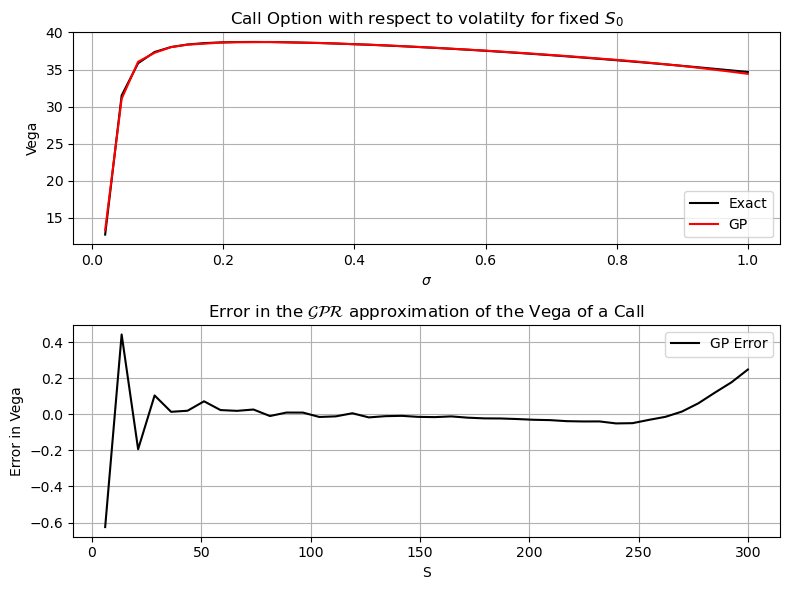

In [102]:

fig, axs = plt.subplots(2, 1, figsize=(8, 6))  # Deux sous-graphiques en colonne

# Premier graphique : Prix exact vs GP
axs[0].plot(x_test, vega((S0-lb)/(ub-lb), x_test), color='black', label='Exact')
axs[0].plot(x_test, f_prime, color='red', label='GP')
axs[0].grid(True)
axs[0].set_xlabel('$\sigma$')
axs[0].set_ylabel('Vega')
axs[0].set_title("Call Option with respect to volatilty for fixed $S_0$")
axs[0].legend()

# Deuxième graphique : Erreur de l'approximation GP
axs[1].plot(lb+(ub-lb)*x_test, vega((S0-lb)/(ub-lb),x_test) - f_prime, color='black', label='GP Error')
axs[1].grid(True)
axs[1].set_xlabel('S')
axs[1].set_ylabel('Error in Vega')
axs[1].set_title(r"Error in the $\mathcal{GPR}$ approximation of the Vega of a Call")
axs[1].legend()

plt.tight_layout()  # Ajuste l'affichage pour éviter le chevauchement
plt.show()


<h3> <center> Testing $\mathcal{GPR}$ with noisy training datas </center> </h3>


<h4> An example with a binary option : </h4> 

In [105]:
def BinaryOptionBS(S0,t,T,K,r,sigma,NbrPaths,NbrSteps):
        # B : Barrière
        # r : Interest Free Rate
        # K : Strike
    
    
    
        dt = (T-t) / NbrSteps
        S=np.ones(([NbrPaths, NbrSteps]))
        #v = np.zeros([NbrPaths, NbrSteps])
        Payoff=np.zeros([NbrPaths,NbrSteps])
        S[:,0]=S0
        
        #mean= [0,0]
        #cov=[[1,rhoAsset],[rhoAsset,1]]
        for j in range(1,NbrSteps):
            WT = np.random.normal(0,1,size=NbrPaths)
        
            S[:,j] = S[:,j-1] + S[:,j-1] * (r*dt + sigma *np.sqrt(dt)* WT)
        #v[:,j]=np.abs(v[:,j-1] + kappa*(theta-v[:,j-1]) *dt +sigma* np.sqrt(v[:,j-1])*WT[:,1])
            
        
        
        
        for i in range(NbrPaths):
            if S[i,-1] > K:
                Payoff[i]=np.exp(-r*(T-t)) * 1
            else:
                Payoff[i]=0
        price=np.mean(Payoff)
        return S,price

<h5> Learnt the prices with  M=10 000 simulations for each price : </h5>

In [106]:
NbrSteps=20
NbrPaths=10000
lb=1
ub=300

BinaryPrice  = lambda x,y: BinaryOptionBS(lb+(ub-lb)*x,t,T,K,r,y,NbrPaths,NbrSteps)[1]
#deltabinarycallprice= lambda x,y: bsformula(1, lb+(ub-lb)*x, K, r, T , y, 0)[5]

x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in tqdm(range(len(x_train))):
    y_train.append(BinaryPrice(x_train[idx], sigma))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L= sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train)
    
k_s = rbf(x_test, x_train)
k_s_prime = (x_train.T - x_test) * k_s / l**2
f_prime = np.dot(k_s_prime, alpha_p)/(ub-lb)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 62.84it/s]
C:\Users\samym\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


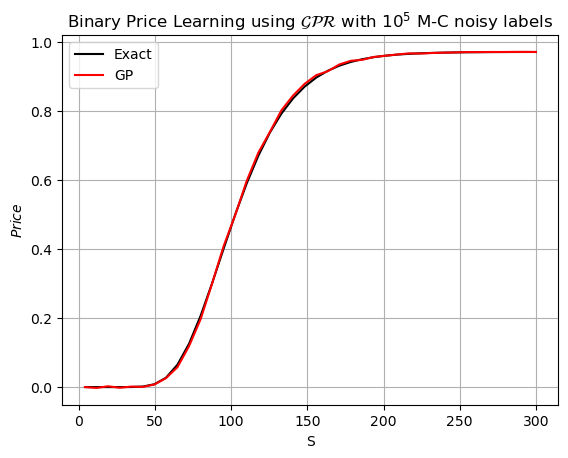

In [108]:
plt.figure()
plt.plot(lb+(ub-lb)*x_test, binarycallprice(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, y_pred, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.title("Binary Price Learning using $\mathcal{GPR}$ with $10^5$ M-C noisy labels")
plt.ylabel('$Price$')
plt.legend()


<h4> Delta of the Binary Option with $M=10 000$ simulations  : </h4> 

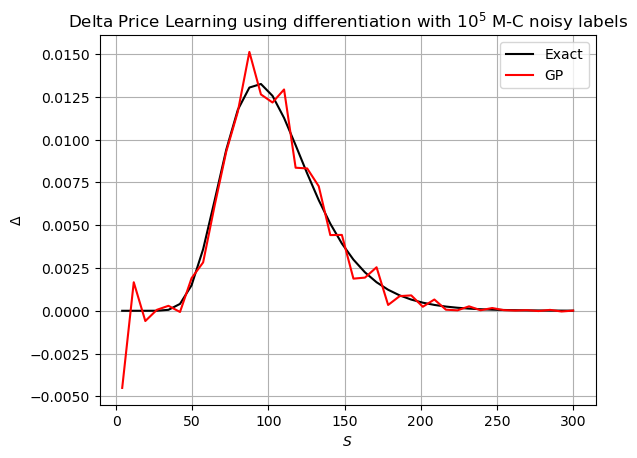

In [109]:
#plt.figure(figsize = (10,6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test,deltabinary(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, f_prime, color = 'red', label = 'GP')
plt.title("Delta Price Learning using differentiation with $10^5$ M-C noisy labels")
plt.grid(True)
plt.xlabel('$S$')
plt.ylabel('$\Delta$')
plt.legend(loc = 'best', prop={'size':10});


<h5> Learnt the price surface with $\mathcal{GPR}$ with  M=1 000 000 simulations for data generation : </h5>

In [110]:
NbrSteps=30
NbrPaths=1000000
lb=1
ub=300

BinaryPrice  = lambda x,y: BinaryOptionBS(lb+(ub-lb)*x,t,T,K,r,y,NbrPaths,NbrSteps)[1]
#deltabinarycallprice= lambda x,y: bsformula(1, lb+(ub-lb)*x, K, r, T , y, 0)[5]

x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in tqdm(range(len(x_train))):
    y_train.append(BinaryPrice(x_train[idx], sigma))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L= sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(L, y_train)
    
k_s = rbf(x_test, x_train)
k_s_prime = (x_train.T - x_test) * k_s / l**2
f_prime = np.dot(k_s_prime, alpha_p)/(ub-lb)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [02:14<00:00,  3.36s/it]
C:\Users\samym\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


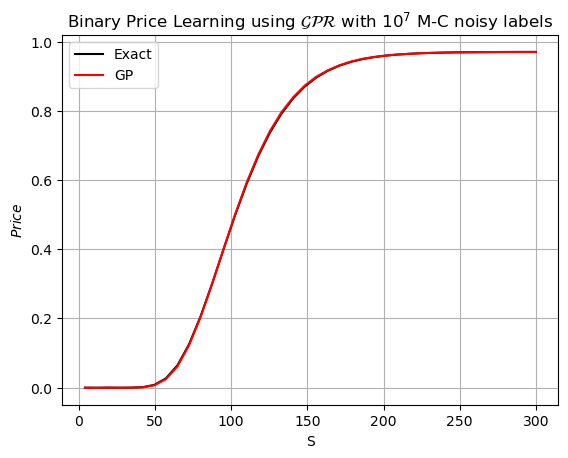

In [111]:
plt.figure()
plt.plot(lb+(ub-lb)*x_test, binarycallprice(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, y_pred, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.title("Binary Price Learning using $\mathcal{GPR}$ with $10^7$ M-C noisy labels")
plt.ylabel('$Price$')
plt.legend()

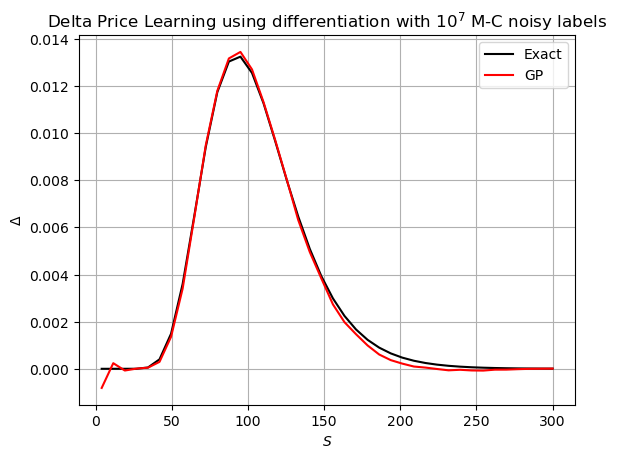

In [112]:
#plt.figure(figsize = (10,6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test,deltabinary(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.title("Delta Price Learning using differentiation with $10^7$ M-C noisy labels")
plt.xlabel('$S$')
plt.ylabel('$\\Delta$')
plt.legend(loc = 'best', prop={'size':10});

<a id=gmmb-insurance></a>
<h3> <center> A GMMB contract in insurance </center> </h3>

A GMMB contract is characterized by the following payoff at maturity $T$. 
\begin{align}
    \mathbb{1}_{\tau > T} \max(S_T,K) \notag.
\end{align}
where :
-  $\tau$ denotes the residual mortality date of the insured starting from $0$ at age x.
-  $S_T$ is the value of the underlying stock at time $T$ with $S_0 \in \mathbb{R}^{*}_{+}$.
-  $K$ is a minimum guarantee for the insured.

We assume the following dynamics for the underlying stock and the mortality rate $\lambda$ for someone aged of $x= 50 Y $ at $t=0$: 

\begin{align} \label{Model GMMB}
    dS_t = S_t (r dt + \sigma dW^{1}_t), \notag  \\
    d\lambda_t = c \lambda_t dt + \xi \sqrt{\lambda_t} dW^{2}_t,  \\
    d<W^1,W^2>_t = \rho dt. \notag
\end{align}

The fair value of the $GMMB$ contract is defined as $t=0$ by :

\begin{align}
    P^{GMMB}_0(S_0,\lambda_0)= \mathbb{E}^{Q} [e^{-rT} \mathbb{1}_{\tau > T} \max(S_T,K)].
\end{align}

In [113]:
def GMMBContractPrice(NbrPaths,kappaλ,sigmaλ,λ0,r,sigma,rho,Y0,K,MaturityContract):
    
    T=50
    dt = T / NbrSteps
    Y=np.ones(([NbrPaths, NbrSteps]))
    λ=np.ones([NbrPaths,NbrSteps])
    Intλ=np.zeros([NbrPaths,NbrSteps])
    Survival=np.ones([NbrPaths,NbrSteps])
    DefaultTime=np.zeros((NbrPaths))
    DefaultProbability=np.ones((NbrSteps))
    DensityProbability=np.zeros((NbrSteps-1))
    
    Payoff = np.zeros((NbrPaths))
    
    index_contract = int(MaturityContract / dt)
    Y[:,0]=Y0
    λ[:,0]=λ0
    timegrid=np.linspace(0,T,NbrSteps+1)
    #mean= [0,0]
    #cov=[[1,rhoAsset],[rhoAsset,1]]
    for j in range(1,NbrSteps):
      

        WTλ = np.random.normal(0,1,size=NbrPaths)*np.sqrt(dt)
        WTY = np.random.normal(0,1,size=NbrPaths)*np.sqrt(dt)

        
        Y[:,j] = Y[:,j-1] + Y[:,j-1] * (r * dt + sigma * WTY)
        λ[:,j] = np.abs( λ[:,j-1]+ kappaλ*λ[:,j-1]*dt + sigmaλ*np.sqrt(λ[:,j-1])*(rho * WTY + np.sqrt(1-rho**2) * WTλ))
       # λ[:,j] =  np.abs(λ[:,j-1]+ kappaλ*λ[:,j-1]*dt + sigmaλ*(rho * WTY + np.sqrt(1-rho**2) * WTλ))
        Intλ[:,j] = Intλ[:,j-1] + ((λ[:,j-1]+λ[:,j])*0.5*dt)
        Survival[:,j]=Survival[:,j-1]*np.exp(-(λ[:,j]+λ[:,j-1])*0.5*dt)
        DefaultProbability[j]=np.mean(Survival[:,j])   
        DensityProbability[j-1]= - (DefaultProbability[j]-DefaultProbability[j-1]) / dt
        
                                        
    exponential_samples=np.random.exponential(size=NbrPaths)
    
    for i in range(NbrPaths):
        exponential_sample=exponential_samples[i]
        current_path=Intλ[i,:]
        if current_path[-1] < exponential_sample:
            DefaultTime[i]= 2 * T
        else:
            j=0
            while current_path[j] < exponential_sample:
                j+=1
            DefaultTime[i]=j*dt
    
    for i in range(NbrPaths):
        default_time=DefaultTime[i]
        if default_time > MaturityContract:
            Payoff[i] = np.exp(-r* MaturityContract) * (np.maximum(Y[i,index_contract],K))
        
    GMMBPrice=np.mean(Payoff)
    
    return GMMBPrice,DefaultProbability,DensityProbability,timegrid
            
            
    
    

Setting the following parameters : 

-  $\xi= 5,97.10^{-4}$
-  $r = 0.02$
-  $c =7,5.10^{-2}$
- $\sigma = 0.2$
- $\rho = -0.7$
- $K=1$

In [187]:
NbrPaths=100000 #Setting the number of paths for the Monte-Carlo.
c=0.0750
xi=0.000597
lambd=0.0087
r=0.02
T=50
y=1
K=1
rho=-0.7
sigma=0.2
MaturityContract=10
GMMBPrice,DefaultProbability,DensityProbability,timegrid = GMMBContractPrice(NbrPaths,c,xi,lambd,r,sigma,rho,y,K,MaturityContract)

<h3> Some plots of $G_{\tau}$ and $f_{\tau}$ : </h3>
    
    
We give below for an insured age of $x=50 \text{ Y} $ the survival function  $G_{\tau}(t)=Q(\tau \leq t)$ of $\tau$ and his density function $f_{\tau}$.
    
  

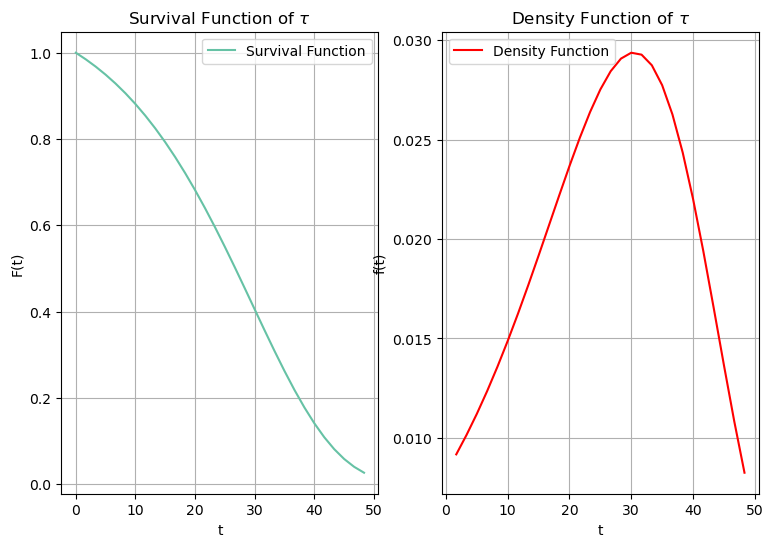

In [52]:

fig, ax = plt.subplots(1, 2, figsize=(9, 6))  # Deux subplots, empilés verticalement

# Premier plot : Survival Function
ax[0].plot(timegrid[0:-1], DefaultProbability, label="Survival Function")
ax[0].set_xlabel("t")
ax[0].set_ylabel("F(t)")
ax[0].set_title("Survival Function of $\\tau$")
ax[0].legend()
ax[0].grid()

# Deuxième plot : Density Function
ax[1].plot(timegrid[1:-1], DensityProbability, label="Density Function", color='r')
ax[1].set_xlabel("t")
ax[1].set_ylabel("f(t)")
ax[1].set_title("Density Function of $\\tau$")
ax[1].legend()
ax[1].grid()

plt.show()


<h4> Generating the training dataset : </h4> 

In [182]:
training_number = 30 # change training size 
testing_number = 40   #use all data as test, otherwise shape not match


x1_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)
x2_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)


X1_train, X2_train = np.meshgrid(x1_train, x2_train)
x_train = np.zeros(len(X1_train.flatten())*2).reshape(len(X2_train.flatten()), 2)
x_train[:,0] = X1_train.flatten()
x_train[:,1] = X2_train.flatten()

<h4> Generating the test dataset  : </h4> 

In [183]:

#x1_test = torch.linspace(0, 1.0, testing_number)
#x2_test = torch.linspace(0.05, 1.0, testing_number)
x1_test = np.array(np.linspace(0.1,0.9, testing_number), dtype='float32').reshape(testing_number, 1)
x2_test = np.array(np.linspace(0.05,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

X1_test, X2_test = np.meshgrid(x1_test, x2_test)

x_test = np.zeros(len(X1_test.flatten())*2).reshape(len(X2_test.flatten()), 2)
x_test[:,0] = X1_test.flatten()
x_test[:,1] = X2_test.flatten()

Training $\mathcal{GPR}$ over a timegrid : 

- Over each timestep of the timegrid, a $\mathcal{GPR}$ is trained so we get a family of $\mathcal{GPR}$ where each $\mathcal{GPR}$ represents the function mapping $(S,\lambda) \mapsto P_{t}(S,\lambda)$ for the corresponding $t$.

In [184]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        
        y_train = []
        
        for idx in tqdm(range(len(x_train))):
            GMMBPrice,DefaultProbability,DensityProbability,timegrid=f(x_train[idx,0], x_train[idx,1], time)
            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_train.append(GMMBPrice)
        y_train = np.array(y_train)
    
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [185]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
            GMMBPrice,DefaultProbability,DensityProbability,timegrid=f(x_test[idx,0], x_test[idx,1], time)

            #y_train.append(PyHeston.HestonCall(lb+interval*x_train[idx,0], x_train[idx,1], K, time, r, lmbda, meanV, sigma, rho, 0.4))
            y_test_.append(GMMBPrice)
            
        print(len(x_test), len(y_test_))
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
        
        
    return y_tests, preds, stds 

In [186]:
lb = 1 #Normalisation for the stock price S
ub = 4
llambda= 0.001 #Normalisation for the mortality rate
ulambda=0.2
portfolio = {}
portfolio['GMMB']={}

portfolio['GMMB']['price']= lambda x,y,z: GMMBContractPrice(NbrPaths,c,xi,llambda + (ulambda- llambda) * y ,r,sigma,rho,lb + (ub-lb)*x,K,z)



In [188]:
nt = 3
T=20
timegrid = np.array(np.linspace(5,T-1,nt), dtype='float32').reshape(nt, 1)

In [190]:
for key in portfolio.keys():
        portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
        portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

  0%|                                                                                          | 0/900 [00:00<?, ?it/s]C:\Users\samym\AppData\Local\Temp\ipykernel_23380\789536680.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_contract = int(MaturityContract / dt)
C:\Users\samym\AppData\Local\Temp\ipykernel_23380\789536680.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Payoff[i] = np.exp(-r* MaturityContract) * (np.maximum(Y[i,index_contract],K))
100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [15:29<00:00,  1.03s/it]
C:\Users\samym\anaconda3\lib\site-packages\sklearn\gaussia

1600 1600


C:\Users\samym\AppData\Local\Temp\ipykernel_23380\789536680.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_contract = int(MaturityContract / dt)
C:\Users\samym\AppData\Local\Temp\ipykernel_23380\789536680.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Payoff[i] = np.exp(-r* MaturityContract) * (np.maximum(Y[i,index_contract],K))


1600 1600


C:\Users\samym\AppData\Local\Temp\ipykernel_23380\789536680.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_contract = int(MaturityContract / dt)
C:\Users\samym\AppData\Local\Temp\ipykernel_23380\789536680.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Payoff[i] = np.exp(-r* MaturityContract) * (np.maximum(Y[i,index_contract],K))


1600 1600


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time to maturity:[15.]


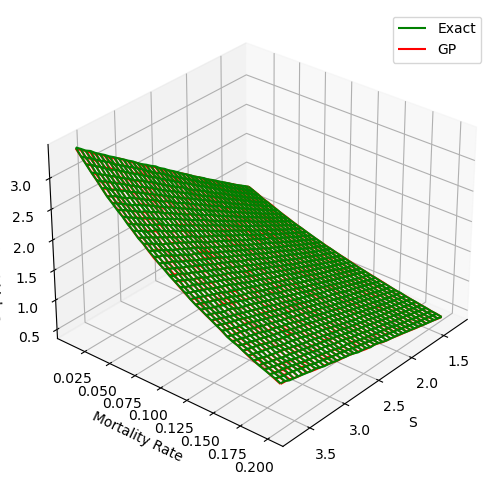

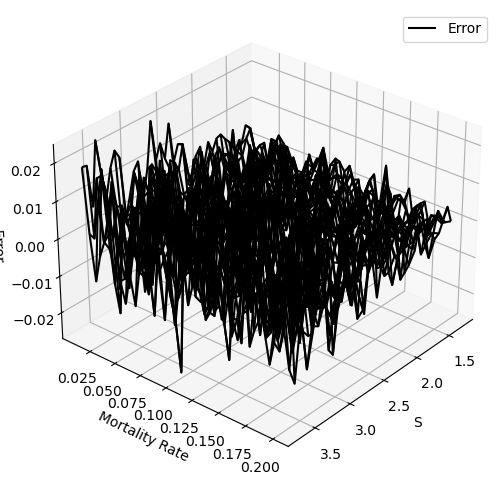

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time to maturity:[8.]


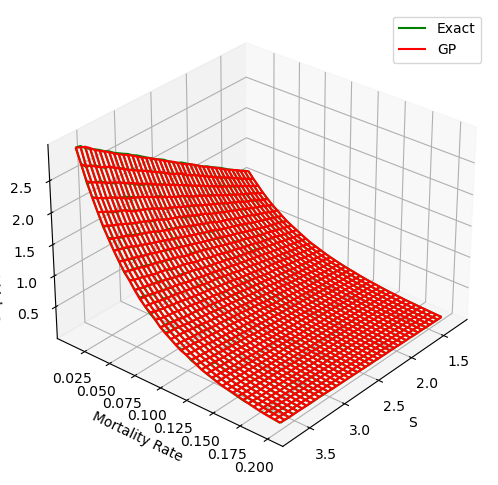

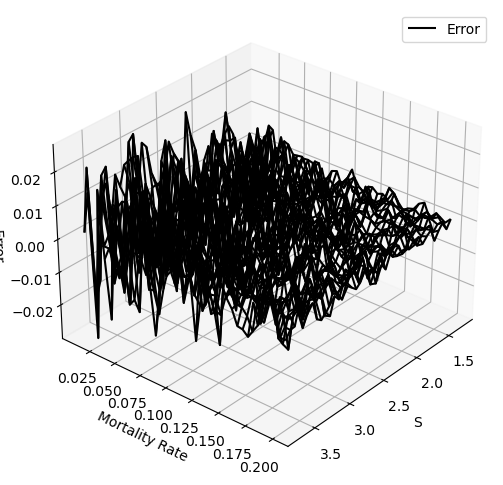

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Time to maturity:[1.]


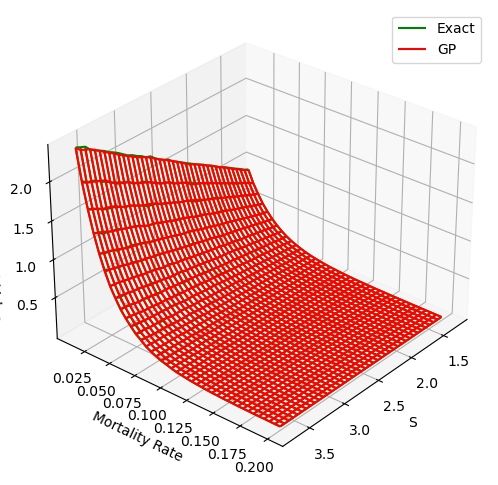

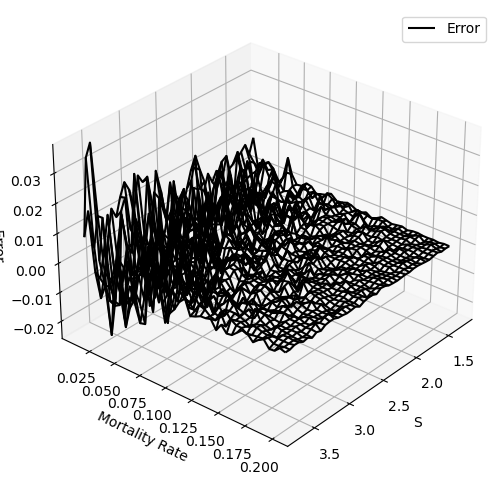

In [191]:
# plot the GP versus the testing data for each point on the timegrid

res = testing_number

x1_plot=lb+(ub-lb)*x_test[:,0].reshape(res,res)
x2_plot=llambda + (ulambda-llambda)*x_test[:,1].reshape(res,res)

for t in range(len(timegrid)):
    print("Time to maturity:" + str(20.0-timegrid[t]))
    plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = plt.axes(projection='3d')


    ax.set_xlabel('S')
    ax.set_ylabel('Mortality Rate')
    ax.set_zlabel('GMMB Contract Value')
    ax.legend(loc = 'best', prop={'size':10})

    pred_plot  =  portfolio['GMMB']['preds'][t].reshape(res,res) 
    test_plot = portfolio['GMMB']['y_tests'][t].reshape(res,res) 

    
    angle = 40
    ax.view_init(30, angle)
    ax.plot_wireframe(x1_plot, x2_plot, test_plot, color='green', label = 'Exact')
    ax.plot_wireframe(x1_plot, x2_plot, pred_plot, color='red', label='GP' )
    ax.set_xlabel('S')
    ax.set_ylabel('Mortality Rate')
    ax.set_zlabel('GMMB Contract Value')
    ax.legend(loc = 'best', prop={'size':10})
    plt.show()
    
    plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = plt.axes(projection='3d')

    
    angle = 40
    ax.view_init(30, angle)
    ax.plot_wireframe(x1_plot, x2_plot, test_plot-pred_plot, color='black', label = 'Error')
    ax.set_xlabel('S')
    ax.set_ylabel('Mortality Rate')
    ax.set_zlabel('Error')
    ax.legend(loc = 'best', prop={'size':10})
    plt.show()
    
    

<a id=gpr-MC></a>
<h2> <center> An application of GPR and Monte-Carlo for CVA computation in finance  </center> </h2>




<a id=what-is-CVA?></a>
<h3> <center> What is Credit Valuation Adjustment ($\textit{CVA}$) ? </center> </h3>


Assuming a probability space $(\Omega,\mathcal{F})$ with $Q$ a risk-neutral probability measure associated to a numeraire $B=(B_t)_{t \geq 0}$ with dynamics $dB_t = B_t r_t dt $ with $r_t$ the short rate, the $CVA$ process can be computed at each time $t \geq 0$ as follows :

\begin{align}
    CVA_t = (1-R^C)  \mathbb{E}^{Q} [\mathbb{1}_{t \leq \tau^C \leq T} (V_{\tau^C})^+  \frac{B_t}{B_{\tau^C}} | \mathcal{G}_t] =(1-R^C)\mathbb{E}^{Q} [\int_{t}^{T} \frac{B_t}{B_s} (V_s)^+  dH_s | \mathcal{G}_t].
\end{align} 
with :
-   $R^C$ the \emph{recovery rate} for the counterparty $C$ such as $LGD=1-R^C$.
-  $V_t$ the product/portfolio value at time $t$ such that $(V_t)^+$ refers to counterparty $\textit{Exposure}$.
-  $T$ the maturity of the product/portfolio.
-   $\tau^C$ the time default of the counterparty $C$ and $H_t = \mathbb{1}_{\tau^C \leq t}$.
-   $\mathcal{F}_t$ the filtration associated with the market information preventing the information of the default time of the counterparty and $\mathcal{H}_t = \sigma((H_u)_{u \leq t})$.
-   $\mathcal{G}_t$  defined as $\mathcal{G}_t = \mathcal{F}_t \vee \mathcal{H}_t$ the lowest filtration making $\tau^C$ a stopping time.


<h4> A remark : </h4>

The computation of $CVA$ involves the computation of the portfolio value at any time which in the most common case needs to be performed using a numerical method like a $Monte-Carlo$ procedure resulting in a nested Monte-Carlo.

 By noting $G(t)=Q(\tau^C>t)$ and by supposing that $\tau^C$ admits a density probability function under $Q$, we can rewrite $CVA_0$ as follows :

\begin{align}\tag{1}
    CVA_0 = - (1-R^C) \int_{0}^{T} \mathbb{E}^{Q} [\frac{(V_t)^+}{B_t} | \tau =t] dG(t). 
\end{align}

Under independance between exposure value of the portfolio and default time, equation (1) can be rewritten over a timegrid $0=t_0 < t_1 < \ldots < t_N = T$ by the following :


\begin{align}\tag{2}
    CVA_0 &\approx - (1-R^C) \sum_{i=0}^{N-1} \mathbb{E}^{Q} [\frac{(V_{t_i})^+}{B_{t_i}}] (G(t_{i+1}) - G(t_{i})).
\end{align}


-  $\mathbb{E}^{Q} [\frac{(V_{t})^+}{B_{t}}]$ is called \emph{Expected Positive Exposure} and is noted $EPE(t)$.
-  $\mathbb{E}^{Q} [\frac{(V_{t})^-}{B_{t}}]$ is called \emph{Expected Negative Exposure} and is noted $ENE(t)$.


<h4> A remark : </h4>

We recover the $3$ components of the credit risk in the $CVA_0$ expression with the the $\textit{Loss Given Default} \text{ (LGD)}$ , the $\textit{Probability of Default} \text{ (PD)}$ and the $\textit{Exposure at Default} \text{ (EAD)}$. 


<a id=cva-GPRMC></a>
<h3> <center> The $\textit{GPR-MC}$ methodology for CVA and applications : </center> </h3>



Using $M$ samples of Monte-Carlo, $CVA_0$ from equation (2) can be approximated as : 

\begin{align}
    CVA_0 \approx - \frac{(1-R^C)}{M} \sum_{j=1}^{M} \sum_{i=0}^{N-1}  \frac{V(t_{i},X^j_{t_{i}})^+}{B^j_{t_{i}}} (G(t_{i+1}) - G(t_i)) 
\end{align}

In a standard nested Monte-Carlo framework, the quantity $V(t_{i},X_{t_{i}^{j}})^+$ should be itself calculated using a $MC$ procedure. The goal of the $\mathcal{GPR}$ will be to learn price surfaces at different dates $t_i$ and evaluate efficiently the quantity $V(t_{i},X_{t_{i}^{j}})^+$ to save one level of the nested Monte-Carlo. Our $\mathcal{GPR-MC}$ estimator can therefore be defined as :

\begin{align}
    \hat{CVA_0} = \frac{(1-R^C)}{M} \sum_{j=1}^{M} \sum_{i=0}^{N-1} \frac{(\mathbb{E}[V_* | X,Y, x^* = X^j_{t_{i}}])^+}{B_{t_i}^j} (G(t_{i+1})-G(t_{i}))
\end{align}


- The calculation of $\mathbb{E}[V_* | X,Y, x^* = X_{t_{i}^{j}}]$ at each time-date $(t_i)_{i \in [\![0;N]\!]}$ is performed using $\mathcal{GPR}$. Therefore, we will have to train as much $\mathcal{GPR}$ as number of timesteps in the discretization of $[0,T]$. As we combined 2 numerical methods, we can take advantage of each of them. $\mathcal{GPR}$ will provide an error on  $EPE$ profile and $MC$ an error on $CVA_0$.

In [165]:
def trainGPs(x_train, f, timegrid):

    gps = []
    i = 0
    for time in timegrid:
        
        y_train = []
        
        for idx in range(len(x_train)):
             y_train.append(f(float(x_train[idx]), float(time)))
        y_train = np.array(y_train)

        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))  #100000.0
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
        i += 1
    return gps   

In [166]:
def predictGPs(x_test, f, gps, timegrid):
    
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_= []
        for idx in range(len(x_test)):
            y_test_.append(f(float(x_test[idx]), float(time)))
            
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        # Find optimal model hyperparameters
        # Set into eval mode
        pred, std = gps[i].predict(x_test,return_std=True)
        preds.append(pred)
        stds.append(std)
        i+=1
    return y_tests, preds, stds 

In [167]:
# specify the portfolio
KC = 100    # Call strike
KP = 100    # Put strike
lb = 0.01
ub = 400
r  = 0
sigma = 0.3
nt = 11
T = 2.0
S0 = 100
timegrid = np.array(np.linspace(0.0,T,nt), dtype='float32').reshape(nt, 1)


portfolio = {}
portfolio['call']={}
portfolio['put']={}

portfolio['call']['price']= lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T-y, sigma, 0)[0]
portfolio['put']['price']= lambda x,y: bsformula(-1, lb+(ub-lb)*x, KP, r, T-y, sigma, 0)[0]


# Change parameters to create a synthetic portfolio

portfolio['call']['weight']=10.0
portfolio['put']['weight']= 5.0

In [168]:
# prepare training and test data
training_number= 50
testing_number = 100
x_train = np.array(np.linspace(0.0,1.0, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.0,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

In [169]:
def CVA_simulation(sim_params, model_params, def_model):
    
    n_sim_dt = sim_params['n_sim_dt'] # number of Euler stpes
    M        = sim_params['M']        # number of paths
    nt       = sim_params['nt']       # number of exposure dates
    timegrid = sim_params['timegrid'] # time grid of exposure dates
    
    r        = model_params['r']
    sigma    = model_params['sigma']
    T        = model_params['T'] 
    t0       = model_params['t0'] 
    S0       = model_params['S0'] 
    
    gamma_0  = def_model['gamma_0']
    
    
    stride = n_sim_dt/(nt-1)
    idx = np.arange(0,n_sim_dt+1,stride, dtype=int)
    pi = {}
    piENE={}
    piENE['tilde'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # GP portfolio value
    piENE['exact'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)
    pi['tilde'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # GP portfolio value
    pi['exact'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)     # BS portfolio value
    pi['tilde_var'] = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M) # GP portfolio variance
    gamma = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)           # hazard rates
    dPD = np.array([0.0]*(nt-1)*M, dtype='float32').reshape((nt-1), M)             # default probabilities
    
    #simulate underlying GBM dynamics using Euler
    S = gbm(S0, r, sigma, T-t0, n_sim_dt, M)
    
    
    for m in range(M):  
      i = 0
      exp_factor=1
        
      for time in timegrid[:len(timegrid)-1]:
        dt = T / (len(timegrid)-1) 
        
        S_= S[idx[i],m] # simulated S
        # avoid simulated S breaching boundaries of domain
        if (S_<lb):
            mins=S_
            S_=lb
        if (S_>ub):
            S_=ub
            maxs=S_
    
        pred_= 0
        v_ = 0
        var_ =0 
    
        for key in portfolio.keys():
           pred, std = portfolio[key]['GPs'][i].predict(np.array([(S_-lb)/(ub-lb)]).reshape(1,-1),return_std=True) 
           pred_ += portfolio[key]['weight']*pred
           var_ += (portfolio[key]['weight']*std)**2 
           if key=='call':
              v_ += portfolio[key]['weight']*bsformula(1, S_, KC, r, T-time, sigma, 0)[0]
           else:
              v_ += portfolio[key]['weight']*bsformula(-1, S_, KP, r, T-time, sigma, 0)[0]
        pi['tilde'][i,m] = np.maximum(pred_,0)
        #print( pi['tilde'][i,m])
        piENE['tilde'][i,m]=np.maximum(-pred_,0)
        pi['exact'][i,m] = np.maximum(v_,0)
        piENE['exact'][i,m]=np.maximum(-v_,0)
        pi['tilde_var'][i,m] =var_ 
        # default intensity model
        gamma[i,m] = gamma_0 # (S0/S_)**gamma_1    
        
        # compute default probabilities  
        exp_factor*=np.exp(-dt*gamma[i-1,m])    
        dPD[i,m]= gamma[i,m]*exp_factor
        
        i += 1
    # compute CVA
    i = 0
    CVA ={}
    CVA['tilde'] = 0
    CVA['exact'] = 0
    CVA['tilde_up'] = 0
    CVA['tilde_down'] = 0
   
    for time in timegrid[:len(timegrid)-1]:
        dt = timegrid[i+1]-timegrid[i]
        mu_tilde = np.mean(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt
        CVA['tilde'] += mu_tilde
        std_err_MC = np.std(dPD[i,:]*pi['tilde'][i,:])*np.exp(-r*(time-t0))*dt/np.sqrt(M)
        CVA['tilde_up'] += mu_tilde + 2.0*std_err_MC
        CVA['tilde_down'] += mu_tilde - 2.0*std_err_MC
        CVA['exact'] += np.mean(dPD[i,:]*pi['exact'][i,:])*np.exp(-r*(time-t0))*dt
        i+=1
    CVA['tilde'] *= (1-def_model['recovery'])
    CVA['tilde_up'] *= (1-def_model['recovery'])
    CVA['tilde_down'] *= (1-def_model['recovery'])
    CVA['exact'] *= (1-def_model['recovery'])
        
    return(CVA, pi,piENE)

<h4> Setting parameters : </h4>

In [170]:
sim_params = {}
model_params = {}
def_model = {}
  
model_params['r'] = r        # risk-free rate
model_params['sigma'] = sigma  # implied volatility
model_params['T'] = T        # Time to maturity 
model_params['t0'] = 0
model_params['S0'] = S0     # Underlying spot
     
# parameters to the default intensity model    
def_model['gamma_0'] = 0.01
def_model['recovery'] = 0.4

sim_params['n_sim_dt'] = 100 # number of Euler stpes
sim_params['M']  = 10000      # number of paths
sim_params['nt'] = nt        # number of exposure dates

sim_params['timegrid']= timegrid # time grid of exposure dates

In [2]:
# train and predict over portfolio
for key in portfolio.keys():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

CVA_0, pi,piENE = CVA_simulation(sim_params, model_params, def_model)

<h3> Portfolio of 10 long Call and 5 long Puts : </h3>

<h4> Printing $CVA_0$, upper and lower bounds : </h4> 

In [172]:
CVA_0 # First Portfolio>

{'tilde': array([2.9905393], dtype=float32),
 'exact': array([2.990539], dtype=float32),
 'tilde_up': array([3.0243156], dtype=float32),
 'tilde_down': array([2.9567633], dtype=float32)}

<h4> Plotting $EPE$ and $ENE$  </h4>

Text(0.5, 1.0, 'Expected Exposure on a Portfolio Of European Options ')

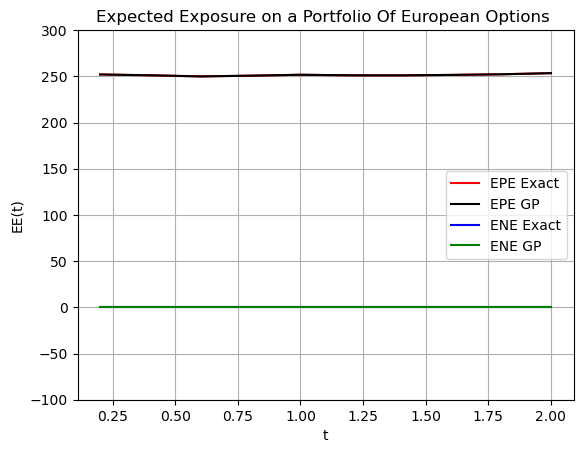

In [181]:
plt.plot(timegrid[1:], np.mean(pi['exact'], axis=1), color = 'red', label = 'EPE Exact')
plt.plot(timegrid[1:],np.mean(pi['tilde'], axis=1), color = "black", label = "EPE GP")
plt.plot(timegrid[1:], - np.mean(piENE['exact'], axis=1), color = 'blue', label = 'ENE Exact')
plt.plot(timegrid[1:], - np.mean(piENE['exact'], axis=1), color = 'green', label = 'ENE GP')

#plt.plot(timegrid[:len(timegrid)-1],[13.07579 for i in range(len(timegrid)-1)],color="green",label="True Value")
plt.legend()
plt.ylim(-100,300)
plt.ylabel("EE(t)")
plt.xlabel("t")
plt.grid()
plt.title("Expected Exposure on a Portfolio Of European Options ")


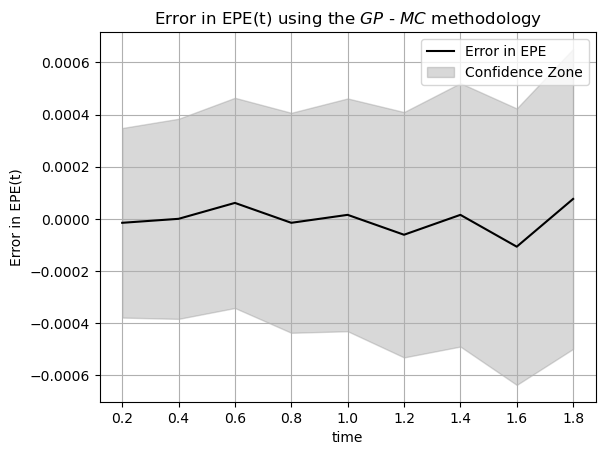

In [179]:
# Error plot
up = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)+2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 
down = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)- 2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 

plt.figure()
plt.plot(timegrid[1:len(timegrid)-1], (np.mean(pi['tilde'], axis=1)-np.mean(pi['exact'], axis=1))[1:], color = 'black', label = 'Error in EPE')
plt.fill_between(timegrid.flatten()[1:len(timegrid)-1], np.array(down)[1:], np.array(up)[1:], color = 'grey', label="Confidence Zone", alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('time')
plt.ylabel('Error in EPE(t)')
plt.title("Error in EPE(t) using the $GP$ - $MC$ methodology")
plt.legend()

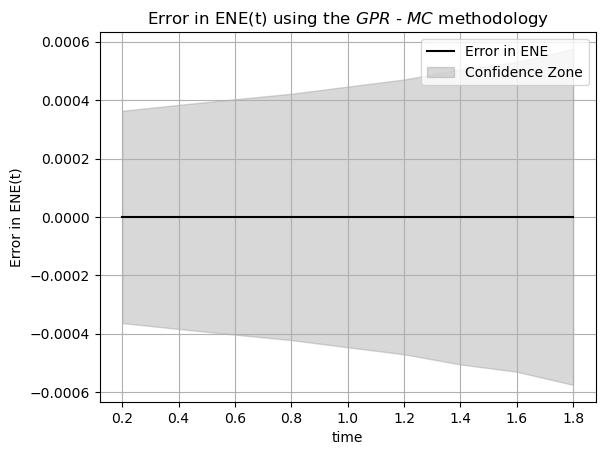

In [180]:
# Error plot
up = np.mean(piENE['tilde'], axis=1) -np.mean(piENE['exact'], axis=1)+2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 
down = np.mean(piENE['tilde'], axis=1) -np.mean(piENE['exact'], axis=1)- 2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 

plt.figure()
plt.plot(timegrid[1:len(timegrid)-1], (np.mean(piENE['tilde'], axis=1)-np.mean(piENE['exact'], axis=1))[1:], color = 'black', label = 'Error in ENE')
plt.fill_between(timegrid.flatten()[1:len(timegrid)-1], np.array(down)[1:], np.array(up)[1:], color = 'grey', label="Confidence Zone", alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('time')
plt.ylabel('Error in ENE(t)')
plt.title("Error in ENE(t) using the $GPR$ - $MC$ methodology")
plt.legend()

<h3> Portfolio of 5 long Call and 5 short Put : </h3>

<h4> Printing $CVA_0$, upper and lower bounds : </h4> 

In [161]:
CVA_0

{'tilde': array([0.61294806], dtype=float32),
 'exact': array([0.6129489], dtype=float32),
 'tilde_up': array([0.6344372], dtype=float32),
 'tilde_down': array([0.59145904], dtype=float32)}

<h4> Plotting $EPE$ and $ENE$  </h4>

Text(0.5, 1.0, 'Expected Exposure on a Forward Replicating  Portfolio ')

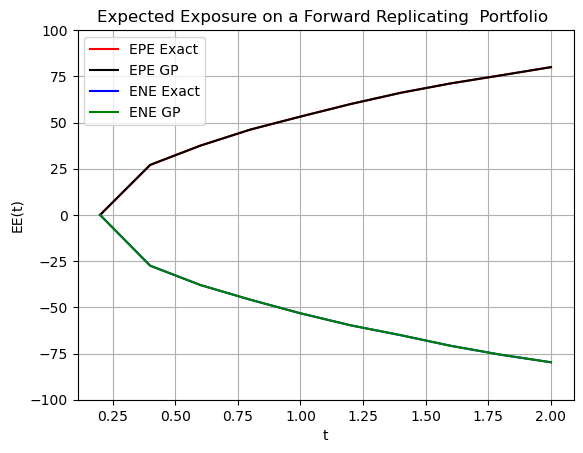

In [162]:
plt.plot(timegrid[1:], np.mean(pi['exact'], axis=1), color = 'red', label = 'EPE Exact')
plt.plot(timegrid[1:],np.mean(pi['tilde'], axis=1), color = "black", label = "EPE GP")
plt.plot(timegrid[1:], - np.mean(piENE['exact'], axis=1), color = 'blue', label = 'ENE Exact')
plt.plot(timegrid[1:], - np.mean(piENE['exact'], axis=1), color = 'green', label = 'ENE GP')

#plt.plot(timegrid[:len(timegrid)-1],[13.07579 for i in range(len(timegrid)-1)],color="green",label="True Value")
plt.legend()
plt.ylim(-100,100)
plt.ylabel("EE(t)")
plt.xlabel("t")
plt.grid()
plt.title("Expected Exposure on a Forward Replicating  Portfolio ")


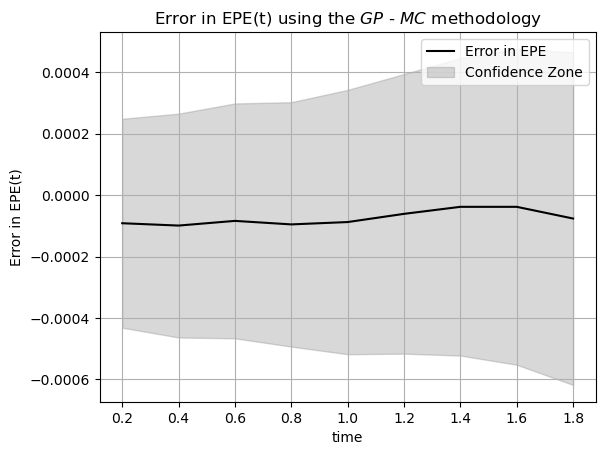

In [163]:
# Error plot
up = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)+2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 
down = np.mean(pi['tilde'], axis=1) -np.mean(pi['exact'], axis=1)- 2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 

plt.figure()
plt.plot(timegrid[1:len(timegrid)-1], (np.mean(pi['tilde'], axis=1)-np.mean(pi['exact'], axis=1))[1:], color = 'black', label = 'Error in EPE')
plt.fill_between(timegrid.flatten()[1:len(timegrid)-1], np.array(down)[1:], np.array(up)[1:], color = 'grey', label="Confidence Zone", alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('time')
plt.ylabel('Error in EPE(t)')
plt.title("Error in EPE(t) using the $GP$ - $MC$ methodology")
plt.legend()

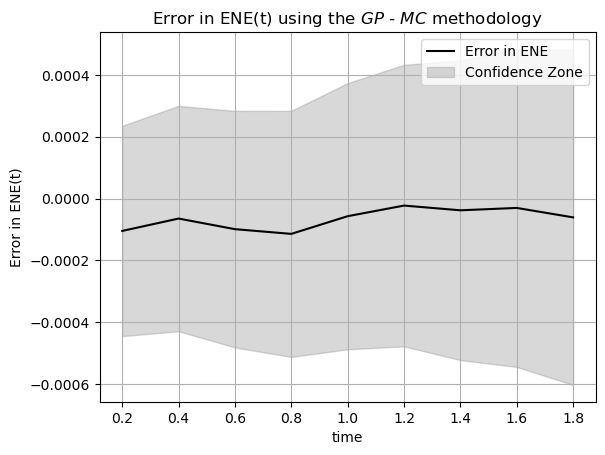

In [164]:
# Error plot
up = np.mean(piENE['tilde'], axis=1) -np.mean(piENE['exact'], axis=1)+2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 
down = np.mean(piENE['tilde'], axis=1) -np.mean(piENE['exact'], axis=1)- 2.0*np.sqrt(np.mean(pi['tilde_var'], axis=1))   # 95% confident interval 

plt.figure()
plt.plot(timegrid[1:len(timegrid)-1], (np.mean(piENE['tilde'], axis=1)-np.mean(piENE['exact'], axis=1))[1:], color = 'black', label = 'Error in ENE')
plt.fill_between(timegrid.flatten()[1:len(timegrid)-1], np.array(down)[1:], np.array(up)[1:], color = 'grey', label="Confidence Zone", alpha=0.3)
plt.grid(True)
#plt.xlim(90, 110)
plt.xlabel('time')
plt.ylabel('Error in ENE(t)')
plt.title("Error in ENE(t) using the $GPR$ - $MC$ methodology")
plt.legend()

<a id=references></a>
<h2> <center> References : </center> </h2>

$\bullet$ $\textit{M.F.Dixon. I.Halperin, P.Bilokon : "Machine Learning in Finance: From Theory to Practice"}$, 2020 available [here](https://link.springer.com/book/10.1007/978-3-030-41068-1)

$\bullet$ $\textit{S.Crépey, M.F.Dixon : "Gaussian Process Regression for Derivative Portfolio
Modeling and Application to CVA Computations"}$, 2019 available [here](https://arxiv.org/pdf/1901.11081)

$\bullet$ $\textit{Carl E. Rasmussen and Christopher K.I. Williams, “Gaussian Processes for Machine Learning”, MIT Press 2006}$ available [here](https://gaussianprocess.org/gpml/chapters/RW.pdf)

$\bullet$ $\textit{J. Gonzalvez, E. Lezmi, T. Roncalli, J. Xu : “Financial applications of
Gaussian processes and Bayesian optimization"}$, 2019 available [here](https://arxiv.org/pdf/1903.04841v1)

$\bullet$ $\textit{K. Barigou, D. Linders, F.Yang : "Actuarial-consistency and two-step actuarial valuations: a
new paradigm to insurance valuation"}$,2022 available [here](https://arxiv.org/pdf/2109.13796)


